<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Walk%20With%20Fastai%20(Zach%20Mueller)%20/WWF_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai -q --upgrade 

     |████████████████████████████████| 194kB 8.3MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 


In [ ]:
!nvidia-smi

# Image Classification Models from Scratch 

In this lecture we will build a model from scratch with the lowest level api of fastai and plus with bit of Pytorch. 

The dataset we will be using in this lecture is MNIST dataset. 

Low-level api --> `Datasets`

### Getting our data ready!

In [ ]:
# Importing the packages we need 
from fastai.vision.all import * 

import torch
from torch import nn 

from fastai.callback.hook import summary 
from fastai.callback.schedule import fit_one_cycle , lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets , DataLoaders , show_at 
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize , GrandparentSplitter , parent_label , ToTensor , IntToFloatTensor , Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy , CrossEntropyLossFlat 

from fastai.vision.augment import CropPad , RandomCrop , PadMode 
from fastai.vision.utils import get_image_files 

In [ ]:
# Loading in the data 
path = untar_data(URLs.MNIST)

In [ ]:
# Getting the filenames because the (Datasets accepts a list of filenames)
items = get_image_files(path)
items[:5]

(#5) [Path('/root/.fastai/data/mnist_png/training/1/6311.png'),Path('/root/.fastai/data/mnist_png/training/1/33663.png'),Path('/root/.fastai/data/mnist_png/training/1/19289.png'),Path('/root/.fastai/data/mnist_png/training/1/40714.png'),Path('/root/.fastai/data/mnist_png/training/1/8430.png')]

The above `items` consists of a list of filenames that had to be passed into a `Datasets`. 

Since we are going to build everything from low-level api we cant use a DataBlock. 

Let's create a image object which is similar to a `ImageBlock`. 

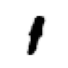

In [ ]:
# Creating a image object that creates a PIL image from a given filename 
im = PILImageBW.create(items[0])
im.show()

Breaking down the above function: 
- `PILImageBW` --> creates a PIL image (pass a filepath) 
- `.create` --> takes care of the preprocessing before going in to the model. This is applicable for both X and y, more like a custom implementation for the various inputs. (Building flexible preprocessing inputs)


In [ ]:
# Splitting our data using the GrandParentSplitter --> looks for train and valid folder 

splits = GrandparentSplitter(train_name = 'training' , valid_name= 'testing')

`split` --> Creates an instance of the object, where passing the items inside this will results in train and val sets. 

`split` itself doesn't do the splitting function, it accepts a list of items to be passed in. 

In [ ]:
# Passing the items into the split method 
splits = splits(items)

In [ ]:
splits[0][3] , splits[1][5]

(3, 60005)

In [ ]:
# What's inside? (training and validation set [0 ,1] indexes)
sample_train = splits[0][:5]
sample_val= splits[1][:5]

sample_train , sample_val

([0, 1, 2, 3, 4], [60000, 60001, 60002, 60003, 60004])

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

#### Building a Datasets
The `Datasets` expects, 
- the items we want to use 
- the transforms (how the inputs and outputs should be contructed and spits out) 
- the splits 

In [ ]:
# Creating the Datasets 
dsrc = Datasets(items , 
                tfms = [[PILImageBW.create] , [parent_label , Categorize]] , 
                splits = splits)


Breaking the above code:
- `items` --> filenames 
- `tfms` --> `[PILImageBW.create]` we are forming the X in here basically creating images and `[parent_label , Categorize]` in here we want our y to be have the labels of the folder (parent_label --> grab labels from folder) and atlast we want to Categorize them. 
- `splits` --> Splitting into train and valid sets. (goes by indexes) 


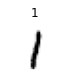

In [ ]:
 # We can look at an item in our Datasets with show_at 

show_at(dsrc.train , 3) # accessing train spit and grabbing 3 indexes file


While building a `DataBlock` we passed the `item_tfms` and `aug_tfms` things like RandomResized and etc.. really easily. 

But now we have to construct the whole pipeline by hand without using any of the ready to go functions. 

We need to give ourselves some transforms on the data! These will need to:
- Ensure our images are all the same size
- Make sure our output are the tensor our models are wanting
- Give some image augmentation

In [ ]:
# Creating transforms for our data by hand (Left to Right)
tfms = [ToTensor() , CropPad(size = 34 , pad_mode= PadMode.Zeros) , RandomCrop(size = 28)]

- `ToTensor`: Converts to tensor
- `CropPad` and `RandomCrop`: Resizing transforms
- Applied on the CPU via `after_item`

This thing works more like a pipeline, after getting the images converts them into a tensor, apply croping and padding 38x38 and atlast randomly cropped by 28x28 pixels. 

The above is the example of how we did an item tfms, we are getting our data ready to get into the batch. 

Next will see about gpu_tfms otherwise called `batch_tfms`

In [ ]:
# Creating the batch tfms 
gpu_tfms = [IntToFloatTensor() , Normalize()]

- `IntToFloatTensor`: Converts to a float
- `Normalize`: Normalizes data (without stats)

Now we have created our `Datasets` the next step would be creating a dataloaders from our datasets. 

In [ ]:
# Building our dataloaders 
dls = dsrc.dataloaders(bs = 128 , after_item= tfms , after_batch= gpu_tfms)

Both `after_item` and `after_batch` says apply item tfms everytime a item is called and apply batch tfms when everytime a batch is called. 

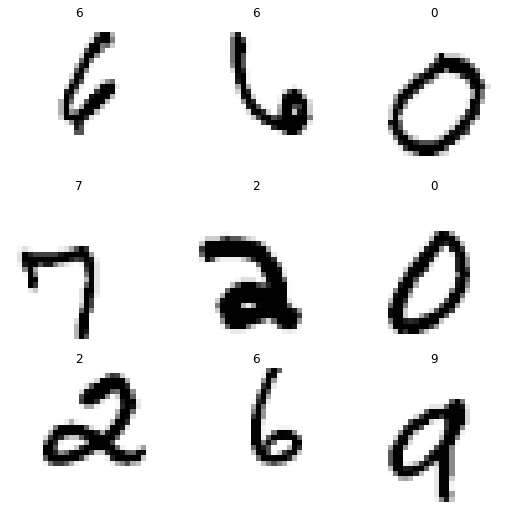

In [ ]:
# Visualizing the batch 
dls.show_batch()

Now we got the dataloaders, the next ultimate step would be training the model with the help of a `Learner`. 

But before that let's see what our model will expect and go through. 

In [ ]:
# Grabbing one batch 
xb , yb = dls.one_batch() 

# Shape of the x and y 
xb.shape , yb.shape 

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

- `torch.Size([128, 1, 28, 28])` --> its our input x which is composed of 1 channel, by 28x28 pixels and it has 128 items in a one batch. 
- `torch.Size([128]))` --> this is our y which is of 128 different labels. 

In [ ]:
# How many classes do we have?
dls.c

10

### The Model 